## Figures

In [1]:
import re

def get_tokens(filename):
    '''open text file and return list of tokens'''
    # text = open(filename, 'r').read().lower()
    f = open(filename, 'r') # open file
    text = f.read() # read file
    text = text.lower() # lower-case text
    tokens = [word for word in re.split('\W', text) if word != ''] # remove punctuation
    return tokens

In [2]:
import pandas as pd

def get_lengths(samples):
    filenames = [sample + '.txt' for sample in samples]
    lengths = {}
    for i in range(len(samples)):
       lengths[samples[i]] = len(get_tokens(filenames[i]))
    return pd.DataFrame(lengths, index = ['words'])

samples = ['Gratian0', 'Gratian1', 'dePen', 'Gratian2']
lengths = get_lengths(samples)
lengths

,Gratian0,Gratian1,dePen,Gratian2
words,3605,56713,10081,14255


In [3]:
def get_features(samples):
    tokens = []
    for sample in samples:
        tokens += get_tokens(sample + '.txt')
    types = list(set(tokens))
    tmp = dict.fromkeys(types, 0)
    for token in tokens: tmp[token] += 1
    features = {
        key: value for key, value in sorted(tmp.items(),
        key = lambda item: (-item[1], item[0]))
    }
    return features

ignore = 'Gratian0'
features = get_features([sample for sample in samples if sample != ignore])
list(features.keys())[:4] # 4 most frequent words (MFWs)

['in', 'non', 'et', 'est']

In [4]:
def get_counts(features, samples):
    columns = {}
    for sample in samples:
        columns[sample] = []
        tmp = get_features([sample])
        for feature in features:
            columns[sample].append(tmp.get(feature, 0))
    return pd.DataFrame(columns, index = features)

counts = get_counts(list(features.keys())[:4], samples)
counts

,Gratian0,Gratian1,dePen,Gratian2
in,74,1450,252,411
non,24,1360,270,306
et,70,1293,260,345
est,13,965,182,167


In [5]:
frequencies = (counts / lengths.values) * 1000
frequencies

,Gratian0,Gratian1,dePen,Gratian2
in,20.527046,25.567330,24.997520,28.831989
non,6.657420,23.980393,26.783057,21.466152
et,19.417476,22.799006,25.791092,24.202034
est,3.606103,17.015499,18.053765,11.715188


In [6]:
samples.remove(ignore)
selected = frequencies[samples]
selected

,Gratian1,dePen,Gratian2
in,25.567330,24.997520,28.831989
non,23.980393,26.783057,21.466152
et,22.799006,25.791092,24.202034
est,17.015499,18.053765,11.715188


In [7]:
means = selected.mean(axis = 1).to_frame('mean')
means

,mean
in,26.465613
non,24.076534
et,24.264044
est,15.594817


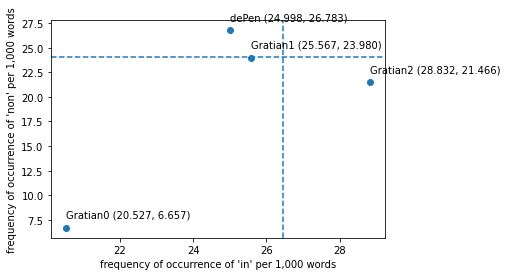

In [8]:
import matplotlib.pyplot as pp

x_values = frequencies.values[0].tolist()
y_values = frequencies.values[1].tolist()
pp.scatter(x_values, y_values)
pp.axhline(means['mean'].tolist()[1], linestyle='dashed')
pp.axvline(means['mean'].tolist()[0], linestyle='dashed')
pp.xlabel(f'frequency of occurrence of \'{frequencies.index.values[0]}\' per 1,000 words')
pp.ylabel(f'frequency of occurrence of \'{frequencies.index.values[1]}\' per 1,000 words')
labels = list(frequencies.columns)
for i in range(len(labels)):
    pp.annotate(
        f'{labels[i]} ({x_values[i]:.3f}, {y_values[i]:.3f})',
        (x_values[i], y_values[i]),
        textcoords="offset points",
        xytext=(0,10),
        ha='left'
    )
# pp.title('(frequency view)')
pp.savefig('./foo') # PNG
# pp.show()

$s=\sqrt{\frac{1}{N - 1}\sum_{i=1}^N(x_i-\bar{x})^2}$

In [9]:
standard_deviations = selected.std(axis = 1).to_frame('std')
standard_deviations

,std
in,2.069051
non,2.659756
et,1.497007
est,3.399727


$z=\frac{x - \bar{x}}{s}$

In [10]:
z_scores = (frequencies - means.values) / standard_deviations.values
z_scores

,Gratian0,Gratian1,dePen,Gratian2
in,-2.870189,-0.434152,-0.709549,1.143701
non,-6.549140,-0.036147,1.017583,-0.981437
et,-3.237506,-0.978645,1.020068,-0.041422
est,-3.526376,0.417881,0.723278,-1.141159


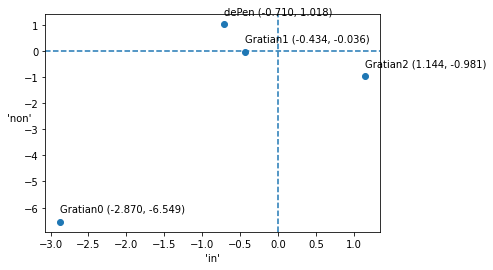

In [11]:
x_values = z_scores.values[0].tolist()
y_values = z_scores.values[1].tolist()
pp.scatter(x_values, y_values)
pp.axhline(linestyle='dashed')
pp.axvline(linestyle='dashed')
pp.xlabel(f'\'{z_scores.index.values[0]}\'')
pp.ylabel(f'\'{z_scores.index.values[1]}\'', rotation = 'horizontal')
labels = list(z_scores.columns)
for i in range(len(labels)):
    pp.annotate(
        f'{labels[i]} ({x_values[i]:.3f}, {y_values[i]:.3f})',
        (x_values[i], y_values[i]),
        textcoords="offset points",
        xytext=(0,10),
        ha='left'
    )
# pp.title('(z-score view)')
# pp.show()

**Again, remember that the means and standard deviations have been computed from the values in the Gratian1 and Gratian2 columns *only*!**

Now, break the consolidated z-scores dateframe into two dataframes: one for the hypothetical case statements (*themata*), the other for the first- and second recension *dicta* (including the *dicta* from *de Pen*.) with which we want to compare the case statements.

In [12]:
test = z_scores[[ignore]]
corpus = z_scores[samples]
test

,Gratian0
in,-2.870189
non,-6.549140
et,-3.237506
est,-3.526376


$\Delta_B = \frac{1}{N}\sum_{i = 1}^N|z_i(t) - z_i(c)|$

In [13]:
# tmp = (corpus - test.values).abs()
tmp = (test.values - corpus).abs()
tmp

,Gratian1,dePen,Gratian2
in,2.436037,2.160640,4.013890
non,6.512993,7.566723,5.567703
et,2.258861,4.257573,3.196083
est,3.944257,4.249654,2.385217


In [14]:
# is there a better way to do this?
deltas = (tmp.mean(axis = 0)).to_frame(ignore).transpose()
deltas

,Gratian1,dePen,Gratian2
Gratian0,3.788037,4.558648,3.790723


Calculating  Burrows's Delta ($\Delta_B$) for Gratian0 with respect to Gratian1 and Gratian2 has limited value. The values of $\Delta_B$ for Gratian0 with respect to both Gratian1 and Gratian2 are the same:

||Gratian1|Gratian2|
|-:|-:|-:|
|**Gratian0**|5.120042|5.120042|

This appears to be related to the problem of mean-of-means comparisons between two samples yielding standard deviations of 1.0 and -1.0.

Adding a third comparison, to the first- and second-recension *dicta* in *de Pen*., makes for a better demo. **Explain and justify the fact that I am separating the first- and second-recension *dicta* in Gratian1 and Gratian2, but keeping them together in dePen.** The values of $\Delta_B$ for Gratian0 with respect to Gratian1, dePen1, and Gratian2 are:

||Gratian1|dePen|Gratian2|
|-:|-:|-:|-:|
|**Gratian0**|3.788037|4.558648|3.790723|

To put those values of $\Delta_B$ in context, if we substitute a 3917-word sample from the pseudo-Augustinian *De vera et falsa penitentia* in place of Gratian0, the values of $\Delta_B$ for pseudo-Augustine with respect to Gratian1, dePen1, and Gratian2 are:

||Gratian1|dePen|Gratian2|
|-:|-:|-:|-:|
|**ps-Aug**|2.691456|1.783147|3.477697|

\[Gratian quotes *De vera et falsa penitentia* extensively in *de Pen*., and the sample was created by concatenating *De Pen*. D.1 c.88, D.3 c.32, D3 c.42, D.3 c.45, D.3 c49, D.5 c.1, D.6 c.1, and D.7 c.6. (This has the incidental advantage of guaranteeing orthographic consistency with the other samples derived from the Friedberg edition.) As noted in Chapter 0 above, *De vera et falsa penitentia* is extremely unlikely to have been written by Gratian. Gratian and pseudo-Augustine had markedly different preferences in postpositive conjunctions: pseudo-Augustine strongly preferred *enim*, while Gratian preferred *autem*. John Wei, *Gratian the Theologian*, 84, describes Gratian's *Decretum* as "the first work to draw on *De vera et falsa penitentia*. **wc -l reports 3918 words, tokenizer reports 3917. Verify that these are all the pseudo-Augustine quotes in *de Pen*. To reproduce March 2014 enim/autem boxplots, use oppose.**\]

In each case, the value of $\Delta_B$ for pseudo-Augustine is *lower* than the corresponding value for Gratian0. Keep in mind that the lowest value of Burrows's Delta ($\Delta_B$) indicates the most likely attribution of authorship. Therefore, pseudo-Augustine is *more* likely than the author of Gratian0 to be author of Gratian1, dePen, and Gratian2 (significantly more likely in the cases of Gratian1 and dePen).

